### Initial Implementation

##### 1. Imports

In [1]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 13.6 MB/s eta 0:00:00


In [2]:
import re
import emoji
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

##### 2. Load Dataset

In [3]:
# load dataset.
data = load_dataset("shainar/BEAD", "Full_Annotations", split="full")
print(data)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.08k [00:00<?, ?B/s]

Full.csv:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text', 'dimension', 'biased_words', 'aspect', 'label', 'sentiment', 'toxic', 'identity_mention'],
    num_rows: 3674927
})


In [4]:
# convert to pandas dataframe.
df = data.to_pandas()
df = df.rename(columns={"label": "bias"})
print(df.head())

                                                text             dimension  \
0  Where will this leave the kids??? That my frie...  Ageism and sentiment   
1   I had a feeling of impending doom &amp; then ...  Ageism and sentiment   
2                                 I no feel good ..   Ageism and sentiment   
3  Back in Hotlanta for a about a week, then off ...  Ageism and sentiment   
4  Kids toys &amp; stamping stuff cleaned up... N...  Ageism and sentiment   

            biased_words          aspect             bias sentiment  toxic  \
0                     []     Transphobia  Slightly Biased  Negative    0.0   
1  ['impending', 'doom']  Climate change    Highly Biased  Negative    1.0   
2                     []    Body-shaming          Neutral  Positive    0.0   
3                     []       Lifestyle  Slightly Biased  Negative    0.0   
4                     []           Hobby          Neutral   Neutral    1.0   

  identity_mention  
0               NO  
1               NO  

In [5]:
# collect approx. 15% of dataset.
df = df.sample(n=600000, random_state=42, replace=True)
print(df.shape)

(600000, 8)


##### 3. Text Pre-processing

In [6]:
# number of empty data items by attribute.
print(df.isnull().sum())

text                    0
dimension               0
biased_words            0
aspect              28877
bias                    0
sentiment               0
toxic                   0
identity_mention        0
dtype: int64


In [7]:
# drop blank texts.
df = df.dropna(subset=['text'])

In [8]:
# drop duplicate texts.
df = df.drop_duplicates(subset='text')

In [9]:
# convert text to 'string'.
df['text'] = df['text'].astype(str)

In [10]:
# clean text.
text = df['text']
text = text.apply(lambda x: x.lower())

def edit(text):
	text = emoji.demojize(text).replace(":", "").replace("_", " ")
	text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text)
	text = re.sub(r'https?://\S+|www\.\S+', '', text)
	text = re.sub(r'[^a-z0-9\s.,!?]', '', text)
	text = re.sub(r'\s+', ' ', text).strip()
	return text

text = text.apply(edit)
df['text'] = text

In [11]:
# find range of text lengths.
print("Min text snippet length:", df['text'].astype('string').apply(len).min())
print("Max text snippet length:", df['text'].astype('string').apply(len).max())
print("Avg text snippet length:", df['text'].astype('string').apply(len).mean())

Min text snippet length: 0
Max text snippet length: 32191
Avg text snippet length: 204.51123249355393


In [12]:
# print record with shortest text.
text_len = df['text'].str.len()
ind = text_len.idxmin()
row = df.loc[ind]
print(row)

text                            
dimension               toxicity
biased_words                  []
aspect              Islamophobia
bias                     Neutral
sentiment                Neutral
toxic                        0.0
identity_mention              NO
Name: 2511439, dtype: object


In [13]:
# drop texts with length < 5.
min_len = 5
ind_drop = df[df['text'].str.len() < min_len].index
print(f"Dropped {len(ind_drop)} rows.")
df.drop(ind_drop, inplace=True)

Dropped 306 rows.


##### 4. Dataset Characteristics

In [14]:
# number of rows.
print(f"{len(df)} rows.")

553133 rows.


In [15]:
# processed text length range.
print("Min text snippet length:", df['text'].astype('string').apply(len).min())
print("Max text snippet length:", df['text'].astype('string').apply(len).max())
print("Avg text snippet length:", df['text'].astype('string').apply(len).mean())

Min text snippet length: 5
Max text snippet length: 32191
Avg text snippet length: 204.62274534334418


In [16]:
# class distribution of 'bias'.
print(df['bias'].value_counts())

bias
Neutral            283808
Slightly Biased    156513
Highly Biased      112812
Name: count, dtype: int64


In [17]:
# class distribution of 'sentiment'.
print(df['sentiment'].value_counts())

sentiment
Positive    252599
Negative    184609
Neutral     115925
Name: count, dtype: int64


In [18]:
# class distribution of 'toxic'.
print(df['toxic'].value_counts())

toxic
0.0    368638
1.0    184495
Name: count, dtype: int64


In [19]:
#TODO: Resampling to resolve class imbalance.

##### 5. Encoding Categorical Columns

In [20]:
# encode categorical columns.
y = pd.DataFrame(data)
target_columns = ['bias', 'sentiment', 'toxic']

encoders = {}
for col in target_columns:
  encoder = LabelEncoder()
  df[col] = encoder.fit_transform(df[col])
  encoders[col] = encoder
  print("Mapping:", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

Mapping: {'Highly Biased': np.int64(0), 'Neutral': np.int64(1), 'Slightly Biased': np.int64(2)}
Mapping: {'Negative': np.int64(0), 'Neutral': np.int64(1), 'Positive': np.int64(2)}
Mapping: {np.float64(0.0): np.int64(0), np.float64(1.0): np.int64(1)}


In [21]:
# print encoded dataset.
print(df.head())

                                                      text  \
2219110  my bestie changed her username to leeshpaugaso...   
2768307  err, your. must be time for bed. im lucky enou...   
2229084           pam 16 gem yup yup yup bitchy tinkerbell   
3511566  and, gee, sometimes even more than a reasonabl...   
2356330  this german story is bogus. if the song was or...   

                    dimension biased_words             aspect  bias  \
2219110  Ageism and sentiment           []        Transphobia     1   
2768307              toxicity           []               None     1   
2229084  Ageism and sentiment   ['bitchy']        Personality     0   
3511566              toxicity           []       Professional     1   
2356330              toxicity           []  Nation stereotype     2   

         sentiment  toxic identity_mention  
2219110          2      0               NO  
2768307          2      1               NO  
2229084          0      1               NO  
3511566          2  

##### 6. Tokenisation & Padding

In [22]:
# tokenize and pad text for deep learning.
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

X = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')

##### 7. Train-Test Split

In [23]:
# target labels.
y = df[['bias', 'sentiment', 'toxic']]
print(y)

         bias  sentiment  toxic
2219110     1          2      0
2768307     1          2      1
2229084     0          0      1
3511566     1          2      0
2356330     2          0      0
...       ...        ...    ...
3490115     0          0      1
3351917     1          2      1
277131      1          2      0
1154965     2          2      1
1140537     1          1      0

[553133 rows x 3 columns]


In [24]:
# split for training, testing anf validation as 80%-10%-10%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [25]:
# convert to numpy.
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_valid:", X_valid.shape)

y_train_bias = y_train["bias"].to_numpy()
y_train_sentiment = y_train["sentiment"].to_numpy()
y_train_toxic = y_train["toxic"].to_numpy()

y_test_bias = y_test["bias"].to_numpy()
y_test_sentiment = y_test["sentiment"].to_numpy()
y_test_toxic = y_test["toxic"].to_numpy()

y_valid_bias = y_valid["bias"].to_numpy()
y_valid_sentiment = y_valid["sentiment"].to_numpy()
y_valid_toxic = y_valid["toxic"].to_numpy()

X_train: (442506, 100)
X_test: (55313, 100)
X_valid: (55314, 100)


##### 8. Model Architecture

In [26]:
# neutrosophic loss function.
def neutrosophic_loss(alpha=1.0, beta=0.5, gamma=0.5, num_classes=None):
    def loss_fn(y_true, y_pred):
        # clip softmax probabilities
        y_pred = K.clip(y_pred, 1e-7, 1.0)

        # convert sparse labels to one-hot
        y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)

        # T (probability of the correct class)
        T = K.sum(y_true_onehot * y_pred, axis=-1)

        # F (probability mass on wrong classes)
        F = 1.0 - T

        # I (normalized shannon entropy)
        entropy = -K.sum(y_pred * K.log(y_pred), axis=-1)
        max_entropy = K.log(tf.cast(num_classes, K.floatx()))
        I = entropy / max_entropy

        # Combine
        loss = -alpha * K.log(T) + beta * F + gamma * I
        return loss
    return loss_fn

In [27]:
# TODO: Integrate sigmoid into the loss function.

In [30]:
embedding_dim = 128

# input layer
input_layer = Input(shape=(X_train.shape[1],))

# hidden layers
x = Embedding(input_dim=MAX_VOCAB, output_dim=embedding_dim, input_length=MAX_LEN)(input_layer)
x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# output layers
output_bias = Dense(len(encoders['bias'].classes_), activation='softmax', name="output_b")(x)
output_sentiment = Dense(len(encoders['sentiment'].classes_), activation='softmax', name="output_s")(x)
output_toxic = Dense(len(encoders['toxic'].classes_), activation='softmax', name="output_t")(x)

model = Model(inputs=input_layer, outputs=[output_bias, output_sentiment, output_toxic])

# compile model
model.compile(
    optimizer="adam",
    loss={
        "output_b": neutrosophic_loss(num_classes=len(encoders['bias'].classes_)),
        "output_s": neutrosophic_loss(num_classes=len(encoders['sentiment'].classes_)),
        "output_t": neutrosophic_loss(num_classes=len(encoders['toxic'].classes_))
    },
    metrics={
        "output_b": "accuracy",
        "output_s": "accuracy",
        "output_t": "accuracy"
    }
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 128)  │  1,280,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     98,816 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_b (Dense)    │ (None, 3)         │        195 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_s (Dense)    │ (None, 3)         │        195 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_t (Dense)    │ (None, 2)         │        130 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,387,848 (5.29 MB)

 Trainable params: 1,387,720 (5.29 MB)

 Non-trainable params: 128 (512.00 B)

##### 9. Model Training

In [31]:
# train model.
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    X_train,
    {
        "output_b": y_train_bias,
        "output_s": y_train_sentiment,
        "output_t": y_train_toxic
    },
    validation_data=(
        X_valid,
        {
            "output_b": y_valid_bias,
            "output_s": y_valid_sentiment,
            "output_t": y_valid_toxic
        }
    ),
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
13829/13829 ━━━━━━━━━━━━━━━━━━━━ 265s 19ms/step - loss: 3.0208 - output_b_accuracy: 0.7137 - output_b_loss: 1.0997 - output_s_accuracy: 0.7714 - output_s_loss: 0.9423 - output_t_accuracy: 0.7514 - output_t_loss: 0.9788 - val_loss: 1.9295 - val_output_b_accuracy: 0.8350 - val_output_b_loss: 0.6904 - val_output_s_accuracy: 0.8904 - val_output_s_loss: 0.5217 - val_output_t_accuracy: 0.8249 - val_output_t_loss: 0.7173
Epoch 2/10
13829/13829 ━━━━━━━━━━━━━━━━━━━━ 267s 19ms/step - loss: 2.0403 - output_b_accuracy: 0.8312 - output_b_loss: 0.7409 - output_s_accuracy: 0.8924 - output_s_loss: 0.5529 - output_t_accuracy: 0.8245 - output_t_loss: 0.7465 - val_loss: 1.8693 - val_output_b_accuracy: 0.8401 - val_output_b_loss: 0.6682 - val_output_s_accuracy: 0.8933 - val_output_s_loss: 0.5052 - val_output_t_accuracy: 0.8302 - val_output_t_loss: 0.6958
Epoch 3/10
13829/13829 ━━━━━━━━━━━━━━━━━━━━ 324s 19ms/step - loss: 1.9231 - output_b_accuracy: 0.8430 - output_b_loss: 0.6931 - output_s_accur

##### 10. Model Evaluation

In [32]:
# evaluate model.
y_pred_probs = model.predict(X_test)

y_pred_bias = np.argmax(y_pred_probs[0], axis=1)
y_pred_sentiment = np.argmax(y_pred_probs[1], axis=1)
y_pred_toxic = np.argmax(y_pred_probs[2], axis=1)

print("====================== Bias Task ======================")
print("Accuracy:", accuracy_score(y_test_bias, y_pred_bias))
print(classification_report(y_test_bias, y_pred_bias, target_names=encoders["bias"].classes_))

print("\n==================== Sentiment Task ====================")
print("Accuracy:", accuracy_score(y_test_sentiment, y_pred_sentiment))
print(classification_report(y_test_sentiment, y_pred_sentiment, target_names=encoders["sentiment"].classes_))

print("\n====================== Toxic Task ======================")
print("Accuracy:", accuracy_score(y_test_toxic, y_pred_toxic))
print(classification_report(y_test_toxic, y_pred_toxic, target_names=[str(cls) for cls in encoders["toxic"].classes_]))

1729/1729 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
====================== Bias Task ======================
Accuracy: 0.847016072171099
                 precision    recall  f1-score   support

  Highly Biased       0.80      0.83      0.81     11282
        Neutral       0.90      0.93      0.92     28380
Slightly Biased       0.77      0.71      0.74     15651

       accuracy                           0.85     55313
      macro avg       0.82      0.82      0.82     55313
   weighted avg       0.84      0.85      0.85     55313


==================== Sentiment Task ====================
Accuracy: 0.8999692658145463
              precision    recall  f1-score   support

    Negative       0.88      0.89      0.88     18460
     Neutral       0.94      0.87      0.90     11593
    Positive       0.90      0.93      0.91     25260

    accuracy                           0.90     55313
   macro avg       0.91      0.89      0.90     55313
weighted avg       0.90      0.90      0.90     55313


==

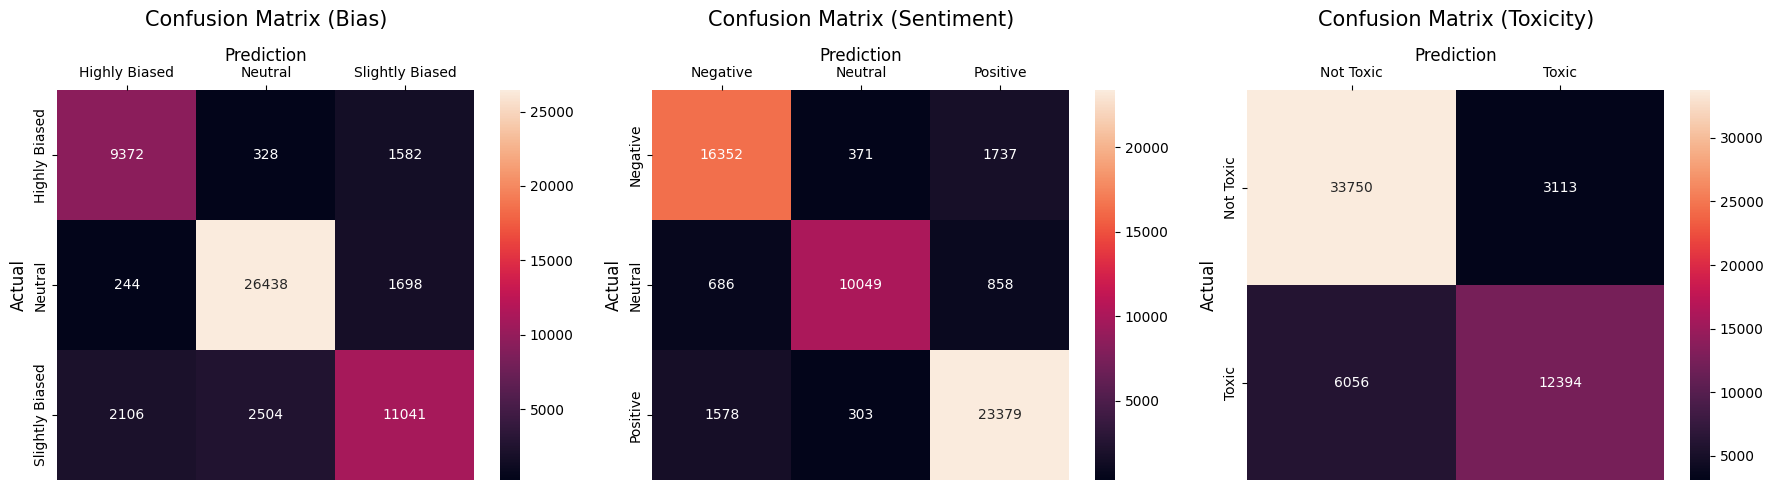

In [33]:
# confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# bias
cm_bias = confusion_matrix(y_test_bias, y_pred_bias)
sns.heatmap(cm_bias, annot=True, fmt='g', xticklabels=['Highly Biased', 'Neutral','Slightly Biased'], yticklabels=['Highly Biased', 'Neutral','Slightly Biased'], ax=axes[0])
axes[0].set_title('Confusion Matrix (Bias)', fontsize=15, pad=15)
axes[0].set_xlabel('Prediction', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].xaxis.set_label_position('top')
axes[0].xaxis.tick_top()

# sentiment
cm_sentiment = confusion_matrix(y_test_sentiment, y_pred_sentiment)
sns.heatmap(cm_sentiment, annot=True, fmt='g', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[1])
axes[1].set_title('Confusion Matrix (Sentiment)', fontsize=15, pad=15)
axes[1].set_xlabel('Prediction', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].xaxis.set_label_position('top')
axes[1].xaxis.tick_top()

# toxicity
cm_toxic = confusion_matrix(y_test_toxic, y_pred_toxic)
sns.heatmap(cm_toxic, annot=True, fmt='g', xticklabels=['Not Toxic', 'Toxic'], yticklabels=['Not Toxic', 'Toxic'], ax=axes[2])
axes[2].set_title('Confusion Matrix (Toxicity)', fontsize=15, pad=15)
axes[2].set_xlabel('Prediction', fontsize=12)
axes[2].set_ylabel('Actual', fontsize=12)
axes[2].xaxis.set_label_position('top')
axes[2].xaxis.tick_top()

plt.tight_layout()
plt.show()

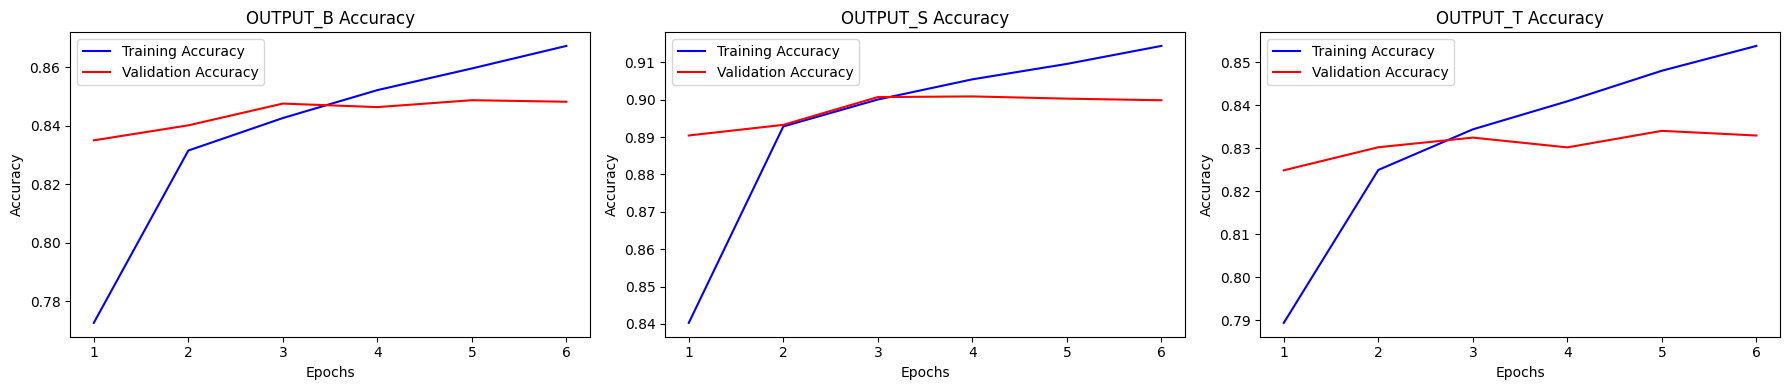

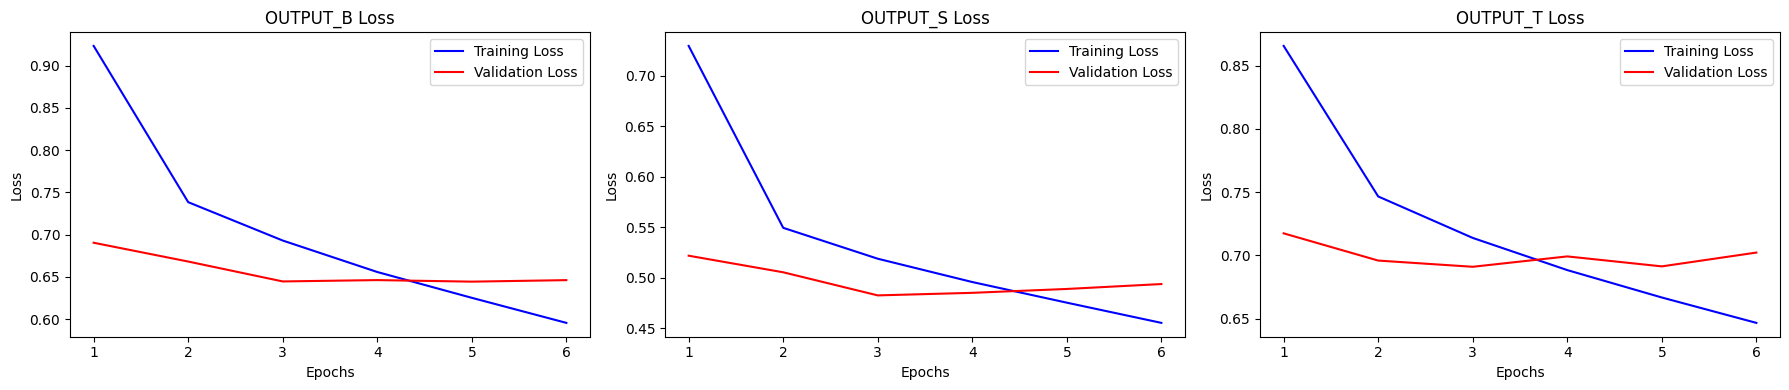

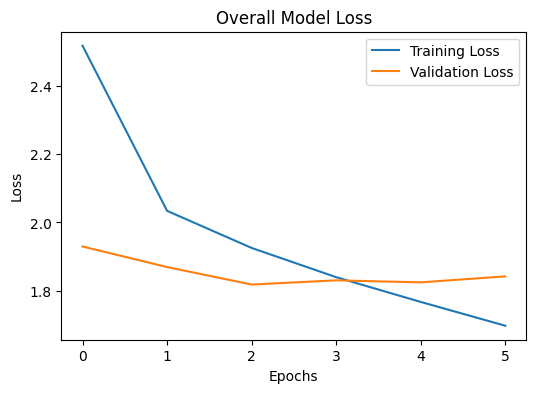

In [45]:
def plot_output(history, outputs, metric="accuracy"):
    epochs = range(1, len(history.history[f"{outputs[0]}_loss"]) + 1)

    # accuracy plot
    fig, axes = plt.subplots(1, len(outputs), figsize=(18, 4))
    for i, output in enumerate(outputs):
        train_metric = history.history[f"{output}_{metric}"]
        val_metric = history.history[f"val_{output}_{metric}"]

        axes[i].plot(epochs, train_metric, "b", label=f"Training {metric.title()}")
        axes[i].plot(epochs, val_metric, "r", label=f"Validation {metric.title()}")
        axes[i].set_title(f"{output.upper()} {metric.title()}")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel(metric.title())
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    # loss plot
    fig, axes = plt.subplots(1, len(outputs), figsize=(18, 4))
    for i, output in enumerate(outputs):
        train_loss = history.history[f"{output}_loss"]
        val_loss = history.history[f"val_{output}_loss"]

        axes[i].plot(epochs, train_loss, "b", label="Training Loss")
        axes[i].plot(epochs, val_loss, "r", label="Validation Loss")
        axes[i].set_title(f"{output.upper()} Loss")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel("Loss")
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    # overall loss
    plt.figure(figsize=(6,4))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Overall Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

outputs = ["output_b", "output_s", "output_t"]
plot_output(history, outputs, metric="accuracy")
